In [1]:
import ee
ee.Initialize()

In [2]:
# Create an TMS miniformat url so that gdal understands the tileset
template =  '''<GDAL_WMS>
    <Service name="TMS">
        <ServerUrl>{url}</ServerUrl>
        <SRS>EPSG:3857</SRS>
    </Service>
    <DataWindow>
        <UpperLeftX>-20037508.34</UpperLeftX>
        <UpperLeftY>20037508.34</UpperLeftY>
        <LowerRightX>20037508.34</LowerRightX>
        <LowerRightY>-20037508.34</LowerRightY>
        <TileLevel>18</TileLevel>
        <TileCountX>1</TileCountX>
        <TileCountY>1</TileCountY>
        <YOrigin>top</YOrigin>
    </DataWindow>
    <Projection>EPSG:3857</Projection>
    <BlockSizeX>256</BlockSizeX>
    <BlockSizeY>256</BlockSizeY>
    <BandsCount>3</BandsCount>
    <Cache>
        <Path>../.gdalwmscache</Path>
        <Extension>.png</Extension>
    </Cache>
</GDAL_WMS>
'''


def export_image(image, bounds, name):
    """download an image for a region and store it as name.png"""
    coords_web = bounds.transform('EPSG:3857', 1).coordinates().getInfo()

    tile_fetcher = image.getMapId()['tile_fetcher']
    url = tile_fetcher.url_format.format(x='${x}', y='${y}', z='${z}')
    
    lr = coords_web[0][1][0], coords_web[0][1][1]
    ul = coords_web[0][3][0], coords_web[0][3][1]

    width = lr[0] - ul[0]
    height = ul[1] - lr[1]
        
    with open(name + '.xml', 'w') as f:
        xml = template.format(url=url)
        f.write(xml)
        
    !gdal_translate {name}.xml -projwin {ul[0]} {ul[1]} {lr[0]} {lr[1]} -outsize 2048 2048 {name}.png

In [3]:
# create a non-geodetic area of interest
bounds = ee.Geometry.Polygon([[
          [-122.75548673853245, 38.0411041965202],
          [-122.75548673853245, 37.64853352930806],
          [-122.11690641626683, 37.64853352930806],
          [-122.11690641626683, 38.0411041965202]]], None, False)

In [4]:
# export DEM
dem = ee.Image("USGS/NED").visualize(**{"min": 0, "max": 700})
export_image(image=dem, name='dem', bounds=bounds)

Input file size is 67108864, 67108864
0...10...20...30...40...50...60...70...80...90...100 - done.


In [46]:
# export water
water_polygons = ee.FeatureCollection("users/gena/OpenStreetMap/water")
water_lines = ee.FeatureCollection("users/gena/OpenStreetMap/waterways")
land = ee.Image("users/gena/land_polygons_image")

water_lines = water_lines.filterBounds(bounds)
water_polygons = water_polygons.filterBounds(bounds)
water = water_lines.merge(water_polygons)
water_image = ee.Image(0).paint(water, 1, 1)

water_ocean = land.unmask(1, False)
water_inland = water_image

# export seperate ocean and inland water 
water_ocean = water_ocean.visualize(**{'min': 0, 'max': 1, 'palette': ['000000', 'ffffff']}).clip(bounds)
water_inland = water_inland.visualize(**{'min': 0, 'max': 1, 'palette': ['000000', 'ffffff']}).clip(bounds)

# export to png
export_image(image=water_ocean, name='water-ocean', bounds=bounds)
export_image(image=water_inland, name='water-inland', bounds=bounds)


Input file size is 67108864, 67108864
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 67108864, 67108864
0...10...20...30...40...50...60...70...80...90...100 - done.


In [64]:
satellite = (
    ee.ImageCollection('COPERNICUS/S2')
      .filterDate('2019-01-01','2020-01-01')
      .filterBounds(bounds)
      .map(lambda i: i.resample('bicubic'))
      .select(['B12', 'B8', 'B4'])
      .reduce(ee.Reducer.percentile([25]))
      .clip(bounds)
      .visualize(**{"min": 300, "max": 2950 })
)
export_image(image=satellite, name='s2', bounds=bounds)



Input file size is 67108864, 67108864
0...10...20...30...40...50...60...70...80...90...100 - done.


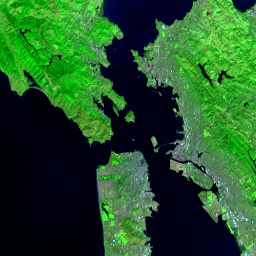

In [63]:
import IPython.display
url = satellite.getThumbUrl(params=dict(dimensions=(256, 256), region=bounds.getInfo()))
IPython.display.Image(url=url, width=256, height=256, format='png', embed=True)

In [6]:
import numpy as np
# encode float to rgba
number = 24.1
arr = np.array(number).astype('float32')
rgba = np.frombuffer(arr.tobytes(), 'uint8').reshape([-1, 4])
arr = np.frombuffer(rgba.tobytes(), 'float32')
assert (arr == number).all()
print('encoded to', np.squeeze(rgba))


encoded to [205 204 192  65]


In [10]:
# Try to do the same in GEE?
number = ee.Number(number)
vi = number.multiply(256 ** 4).toFloat()
ex = vi.divide(256 ** 3).mod(256).toUint8().getInfo()
ey = vi.divide(256 ** 2).mod(256).toUint8().getInfo()
ez = vi.divide(256 ** 1).mod(256).toUint8().getInfo()
ew = vi.divide(256 ** 0).mod(256).toUint8().getInfo()
# not quite
ex, ey, ez, ew

(25, 153, 153, 153)

In [26]:
import struct
number = 24.1
buffer = struct.pack('<f', number)
rgba = struct.unpack('4B', buffer)
buffer = struct.pack('4B', *rgba)
arr = struct.unpack('<f', buffer)
arr, rgba

((24.100000381469727,), (205, 204, 192, 65))

In [29]:
import skimage.io
import skimage.filters

In [41]:
img = skimage.io.imread('dem.png')



In [40]:
vi = np.array((24.1 * (256**4)), 'float32')


24.0